In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
REWARD = 100

In [5]:
seed = 7551
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 0 #masscart, masspole, length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [6]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  4MPGEE3V_00_21_24
NN-MODEL FILENAME:  ./models/4MPGEE3V_00_21_24_NN.pt


In [7]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [8]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s     = borders
    
    indx = np.empty_like(value).astype(np.intp)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax().astype(np.intp)
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.intp)
    return indx



In [9]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [10]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 500   # target update frequency
MIN_MEMORY_CAP      = 200000

In [11]:
MAX_NO_OF_ITERATIONS = 50
MAX_NN_ITERATIONS    = 50000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  50


In [12]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.memory_counter      = 0
        self.memory              = np.zeros((int(MIN_MEMORY_CAP), N_STATES * 2 + 2)) # initialize memory
        
#         self.good_memory_counter = 0 # for storing non-terminal memories
#         self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
#         self.bad_memory_counter  = 0 # for storing terminal memories
#         self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        self.running_loss        = 0
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action
    
    def get_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions = self.eval_net.forward(x).view(-1,N_ACTIONS).max(1)[1].data.numpy().astype(np.intp)
#         actions_value 
#         action = torch.max(actions_value, 1)[1].data.numpy()
#         action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return actions
    
    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        
        sample_index_limit = min(MIN_MEMORY_CAP, self.memory_counter)
        sample_index = np.random.choice(int(sample_index_limit),int(BATCH_SIZE))
        b_memory = self.memory[sample_index,:]
#         # sample batch transitions
#         good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
#         bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

#         good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
#         bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

#         b_good_memory = self.good_memory[good_sample_index, :]
#         b_bad_memory  = self.bad_memory[bad_sample_index, :]
#         b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER), end="\t")
            self.running_loss = 0.0

In [13]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [14]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.6
C_POS_ABS_MIN = -2.6

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

In [15]:
# SET GRANULARITY
HI_GRAIN = 40
print("HI_GRAIN = ", HI_GRAIN)

HI_GRAIN =  40


In [16]:
def mp_node_run(node_id, boundary, iteration, node_q_table):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################


    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_ABS_MIN,  C_POS_ABS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_ABS_MIN,  C_VEL_ABS_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_ABS_MIN,  P_ANG_ABS_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_ABS_MIN,  P_VEL_ABS_MAX,  HI_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s]
    ###############################################
    
    my_Q_TABLE = node_q_table

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
#     if iteration < 3:
    my_EPSILON   = np.clip(((3%5 + 1)*0.1 + (iteration)*0.2) ,0.4,0.98)+ np.random.uniform(-0.01,0.01)
#     print(node_id, my_EPSILON)
#     else:
#         my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0
            
            s = my_env.reset()
            
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = (node_id%N_ACTIONS)#np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state]

                 # take action
                s_, r, done, info = my_env.step(a)

                if done:
                    r = -REWARD
                    if time_steps >= TIMESTEP_LIMIT:
                        r = REWARD
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN] = [exp_rec[:,i].min() for i in range(N_STATES)]

    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN]
    
    return exp_rec, time_rec, newboundary

In [17]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [18]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN])



# # GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
# np.save(node_QFILE, init_q_table)

peak memory: 1321.77 MiB, increment: 1101.48 MiB
Quantization TIME:  0.02 minutes


In [19]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES
node_q_table = init_q_table



ITERATION # 0
TOTAL EXPERIENCE GENERATED:   14648
SMALLEST TIMESTEP: 8
LARGEST  TIMESTEP: 75
TOTAL SERIAL TIMESTEPS:   14648
TOTAL PARALLEL TIMESTEPS: 75


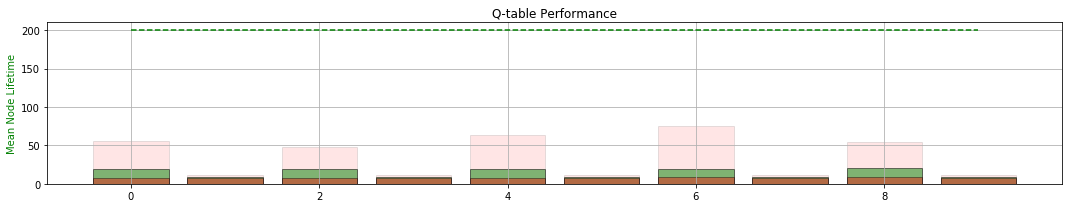

MEMORY COUNTER:  14648
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 574.463	LOSS : 554.263	LOSS : 530.684	LOSS : 493.575	LOSS : 497.108	LOSS : 514.308	LOSS : 475.025	LOSS : 493.916	LOSS : 490.402	LOSS : 464.461	LOSS : 474.263	LOSS : 481.712	LOSS : 449.005	LOSS : 445.228	LOSS : 442.397	LOSS : 452.630	LOSS : 426.974	LOSS : 434.939	LOSS : 434.280	LOSS : 424.710	
Validating... MEAN TIME:  109.25
LOSS : 417.723	LOSS : 409.857	LOSS : 384.228	LOSS : 409.187	LOSS : 396.480	LOSS : 408.523	LOSS : 389.700	LOSS : 379.751	LOSS : 394.388	LOSS : 390.310	LOSS : 390.152	LOSS : 386.158	LOSS : 383.447	LOSS : 373.309	LOSS : 364.424	LOSS : 375.668	LOSS : 376.392	LOSS : 379.515	LOSS : 364.648	LOSS : 364.839	
Validating... MEAN TIME:  137.075
LOSS : 375.607	LOSS : 369.596	LOSS : 361.243	LOSS : 363.516	LOSS : 366.901	LOSS : 365.904	LOSS : 353.108	LOSS : 356.627	LOSS : 351.591	LOSS : 351.055	LOSS : 352.937	LOSS : 346.141	LOSS : 351.267	LOSS : 350.642	LOSS : 349.006	LOSS : 348.622	LOSS : 36

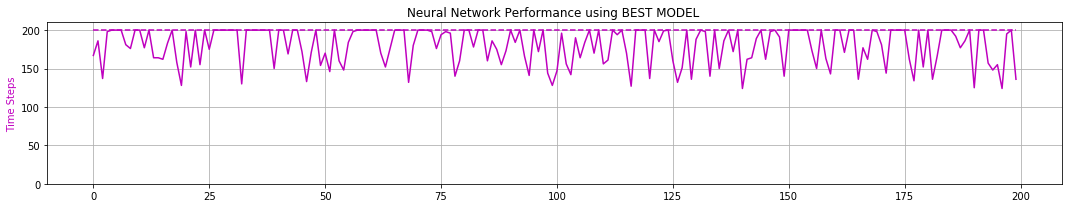

peak memory: 1361.05 MiB, increment: 1083.40 MiB
0 -max- [ 0.223  1.281  0.209  2.739]
0 -min- [-0.743 -2.509 -0.208 -1.922]

1 -max- [ 0.193  1.908  0.049  0.048]
1 -min- [-0.050 -0.047 -0.208 -2.947]

2 -max- [ 0.183  1.394  0.209  2.753]
2 -min- [-0.463 -2.118 -0.209 -2.170]

3 -max- [ 0.190  1.907  0.050  0.048]
3 -min- [-0.049 -0.049 -0.209 -2.968]

4 -max- [ 0.157  1.344  0.208  2.627]
4 -min- [-0.574 -2.127 -0.209 -2.119]

5 -max- [ 0.215  1.986  0.050  0.048]
5 -min- [-0.050 -0.050 -0.209 -2.972]

6 -max- [ 0.160  1.159  0.209  2.910]
6 -min- [-1.140 -2.507 -0.207 -1.652]

7 -max- [ 0.229  1.988  0.049  0.049]
7 -min- [-0.050 -0.049 -0.209 -2.943]

8 -max- [ 0.240  1.370  0.209  2.757]
8 -min- [-0.434 -2.495 -0.209 -2.038]

9 -max- [ 0.205  1.961  0.049  0.050]
9 -min- [-0.049 -0.049 -0.209 -2.970]

Quantization TIME:  0.02 minutes


ITERATION # 1
TOTAL EXPERIENCE GENERATED:   44649
SMALLEST TIMESTEP: 9
LARGEST  TIMESTEP: 198
TOTAL SERIAL TIMESTEPS:   59297
TOTAL PARALLEL TIMES

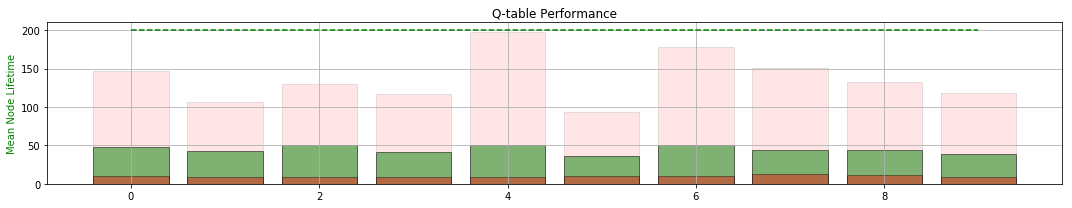

MEMORY COUNTER:  59297
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 355.414	LOSS : 350.585	LOSS : 329.904	LOSS : 324.238	LOSS : 325.725	LOSS : 316.403	LOSS : 317.255	LOSS : 301.211	LOSS : 301.369	LOSS : 302.559	LOSS : 310.277	LOSS : 304.587	LOSS : 287.774	LOSS : 301.158	LOSS : 298.396	LOSS : 293.263	LOSS : 290.418	LOSS : 303.953	LOSS : 293.177	LOSS : 301.971	
Validating... MEAN TIME:  160.845
LOSS : 293.231	LOSS : 298.937	LOSS : 292.383	LOSS : 291.715	LOSS : 312.698	LOSS : 312.333	LOSS : 294.799	LOSS : 295.606	LOSS : 304.416	LOSS : 306.787	LOSS : 304.959	LOSS : 297.932	LOSS : 307.285	LOSS : 312.629	LOSS : 308.466	LOSS : 313.984	LOSS : 307.504	LOSS : 321.085	LOSS : 309.092	LOSS : 329.950	
Validating... MEAN TIME:  174.12
LOSS : 310.328	LOSS : 314.265	LOSS : 311.817	LOSS : 323.593	LOSS : 307.112	LOSS : 305.896	LOSS : 328.385	LOSS : 316.110	LOSS : 319.033	LOSS : 324.007	LOSS : 318.632	LOSS : 319.441	LOSS : 322.385	LOSS : 321.233	LOSS : 323.973	LOSS : 318.151	LOSS : 34

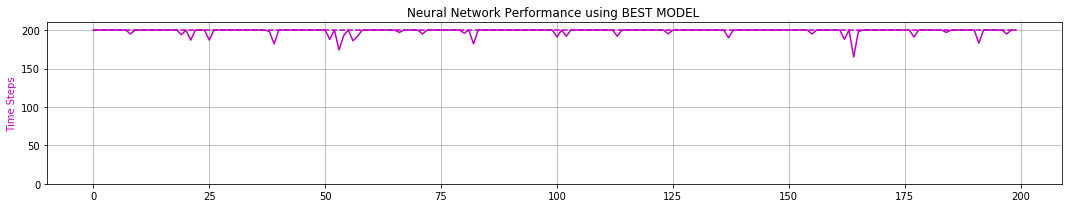

peak memory: 1422.57 MiB, increment: 1083.44 MiB
0 -max- [ 0.943  1.855  0.209  2.509]
0 -min- [-0.326 -1.521 -0.050 -1.087]

1 -max- [ 0.196  1.574  0.051  1.478]
1 -min- [-1.215 -2.111 -0.209 -2.413]

2 -max- [ 0.754  1.647  0.209  2.958]
2 -min- [-0.297 -1.926 -0.055 -1.118]

3 -max- [ 0.181  1.580  0.050  1.610]
3 -min- [-0.955 -1.815 -0.209 -2.570]

4 -max- [ 1.082  1.803  0.209  2.750]
4 -min- [-0.442 -1.804 -0.060 -1.181]

5 -max- [ 0.204  1.523  0.050  1.284]
5 -min- [-1.065 -1.657 -0.209 -2.459]

6 -max- [ 0.988  1.846  0.209  2.871]
6 -min- [-1.245 -1.896 -0.123 -1.292]

7 -max- [ 0.230  1.724  0.051  1.452]
7 -min- [-1.240 -2.043 -0.209 -2.649]

8 -max- [ 0.901  1.436  0.209  2.482]
8 -min- [-0.249 -1.591 -0.049 -1.204]

9 -max- [ 0.208  1.393  0.047  1.257]
9 -min- [-1.345 -2.070 -0.209 -2.329]

Quantization TIME:  0.02 minutes


ITERATION # 2
TOTAL EXPERIENCE GENERATED:   94869
SMALLEST TIMESTEP: 9
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   154166
TOTAL PARALLEL TIME

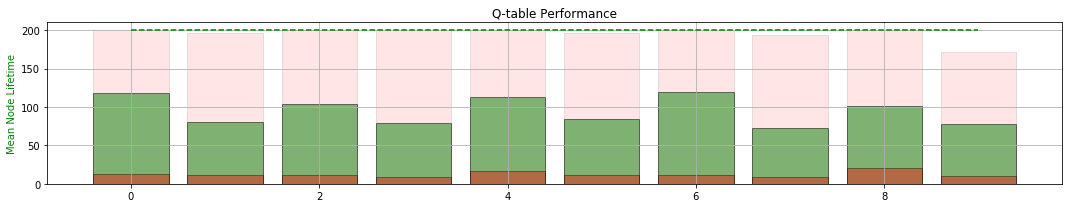

MEMORY COUNTER:  154166
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 325.906	LOSS : 307.593	LOSS : 303.060	LOSS : 301.201	LOSS : 288.751	LOSS : 283.665	LOSS : 285.730	LOSS : 271.154	LOSS : 281.071	LOSS : 275.753	LOSS : 243.498	LOSS : 250.101	LOSS : 256.721	LOSS : 264.143	LOSS : 269.770	LOSS : 256.788	LOSS : 250.430	LOSS : 248.262	LOSS : 237.533	LOSS : 245.399	
Validating... MEAN TIME:  169.42
LOSS : 244.985	LOSS : 239.404	LOSS : 242.455	LOSS : 241.299	LOSS : 238.563	LOSS : 245.907	LOSS : 241.255	LOSS : 231.347	LOSS : 229.066	LOSS : 231.049	LOSS : 231.867	LOSS : 230.098	LOSS : 234.639	LOSS : 234.941	LOSS : 235.214	LOSS : 240.187	LOSS : 241.618	LOSS : 230.175	LOSS : 229.469	LOSS : 231.877	
Validating... MEAN TIME:  182.73
LOSS : 229.223	LOSS : 224.341	LOSS : 235.620	LOSS : 233.890	LOSS : 240.252	LOSS : 231.817	LOSS : 234.550	LOSS : 231.520	LOSS : 230.835	LOSS : 230.647	LOSS : 231.654	LOSS : 235.625	LOSS : 244.239	LOSS : 246.049	LOSS : 242.226	LOSS : 228.247	LOSS : 22

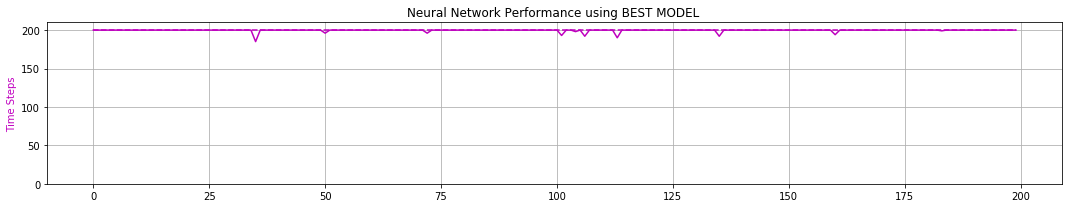

peak memory: 1441.77 MiB, increment: 1018.61 MiB
0 -max- [ 2.398  2.759  0.209  2.535]
0 -min- [-2.373 -2.235 -0.205 -1.965]

1 -max- [ 0.211  1.363  0.093  1.841]
1 -min- [-2.211 -2.661 -0.209 -2.101]

2 -max- [ 2.375  2.557  0.209  2.584]
2 -min- [-1.315 -1.750 -0.157 -1.938]

3 -max- [ 0.250  1.390  0.083  1.768]
3 -min- [-2.210 -2.464 -0.209 -2.233]

4 -max- [ 2.386  2.780  0.209  2.601]
4 -min- [-0.952 -1.599 -0.128 -1.940]

5 -max- [ 0.208  1.426  0.100  1.824]
5 -min- [-2.161 -2.518 -0.209 -2.497]

6 -max- [ 2.399  2.738  0.209  2.457]
6 -min- [-2.332 -2.550 -0.201 -1.952]

7 -max- [ 0.225  1.589  0.090  1.938]
7 -min- [-2.263 -2.420 -0.209 -2.462]

8 -max- [ 2.377  2.445  0.209  2.201]
8 -min- [-2.161 -2.199 -0.205 -1.938]

9 -max- [ 0.184  1.548  0.090  1.851]
9 -min- [-2.179 -2.462 -0.209 -2.489]

Quantization TIME:  0.02 minutes


ITERATION # 3
TOTAL EXPERIENCE GENERATED:   187257
SMALLEST TIMESTEP: 19
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   341423
TOTAL PARALLEL TI

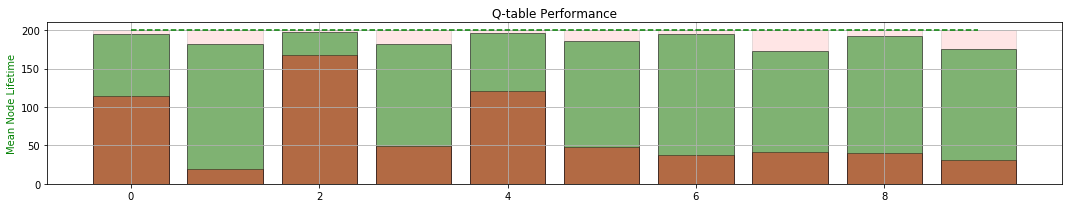

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 152.424	LOSS : 140.488	LOSS : 125.940	LOSS : 114.829	LOSS : 108.064	LOSS : 96.355	LOSS : 93.892	LOSS : 86.009	LOSS : 78.446	LOSS : 94.894	LOSS : 71.888	LOSS : 91.497	LOSS : 86.656	LOSS : 87.952	LOSS : 84.227	LOSS : 80.020	LOSS : 82.064	LOSS : 81.004	LOSS : 73.169	LOSS : 87.047	
Validating... MEAN TIME:  92.105
LOSS : 90.911	LOSS : 83.209	LOSS : 79.951	LOSS : 79.944	LOSS : 87.727	LOSS : 77.193	LOSS : 83.210	LOSS : 72.915	LOSS : 86.131	LOSS : 89.420	LOSS : 83.489	LOSS : 71.873	LOSS : 81.803	LOSS : 73.120	LOSS : 74.820	LOSS : 68.732	LOSS : 75.113	LOSS : 72.720	LOSS : 61.005	LOSS : 63.740	
Validating... MEAN TIME:  95.47
LOSS : 68.072	LOSS : 66.811	LOSS : 68.574	LOSS : 76.778	LOSS : 67.315	LOSS : 70.144	LOSS : 62.872	LOSS : 62.927	LOSS : 64.256	LOSS : 64.712	LOSS : 70.502	LOSS : 69.425	LOSS : 67.659	LOSS : 80.383	LOSS : 70.699	LOSS : 71.376	LOSS : 63.437	LOSS : 58.879	LOSS : 63.143	LOSS : 61.502	
Vali

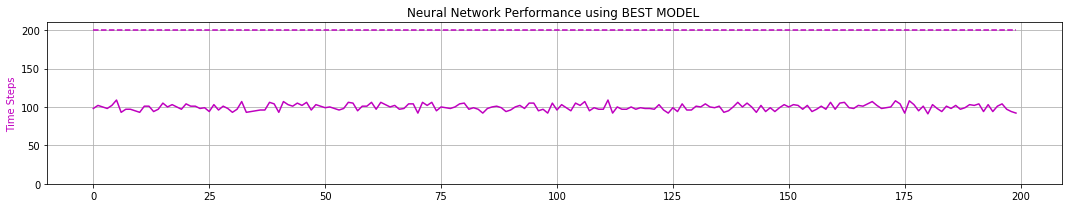

peak memory: 1431.46 MiB, increment: 1017.84 MiB
0 -max- [ 1.599  1.878  0.203  1.673]
0 -min- [-2.399 -2.917 -0.209 -2.047]

1 -max- [ 1.174  1.555  0.139  1.434]
1 -min- [-2.400 -3.287 -0.209 -1.963]

2 -max- [ 1.338  1.924  0.209  1.647]
2 -min- [-2.398 -2.762 -0.209 -2.153]

3 -max- [ 1.006  1.553  0.135  1.364]
3 -min- [-2.398 -2.960 -0.209 -2.016]

4 -max- [ 1.492  1.865  0.190  1.750]
4 -min- [-2.399 -3.172 -0.209 -2.148]

5 -max- [ 1.119  1.582  0.152  1.372]
5 -min- [-2.398 -3.368 -0.209 -1.960]

6 -max- [ 1.190  1.907  0.208  1.907]
6 -min- [-2.399 -3.298 -0.208 -1.984]

7 -max- [ 0.867  1.582  0.147  1.367]
7 -min- [-2.400 -3.341 -0.209 -2.220]

8 -max- [ 1.182  1.745  0.206  2.106]
8 -min- [-2.396 -3.159 -0.209 -2.134]

9 -max- [ 1.441  1.585  0.141  1.367]
9 -min- [-2.398 -3.309 -0.209 -2.162]

Quantization TIME:  0.01 minutes


ITERATION # 4
TOTAL EXPERIENCE GENERATED:   105590
SMALLEST TIMESTEP: 21
LARGEST  TIMESTEP: 125
TOTAL SERIAL TIMESTEPS:   447013
TOTAL PARALLEL TI

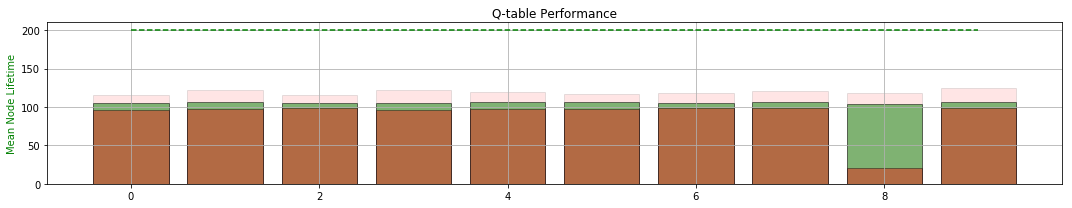

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 89.977	LOSS : 77.255	LOSS : 74.321	LOSS : 86.363	LOSS : 71.424	LOSS : 94.336	LOSS : 75.283	LOSS : 88.042	LOSS : 78.597	LOSS : 75.697	LOSS : 78.202	LOSS : 77.461	LOSS : 82.720	LOSS : 71.728	LOSS : 78.588	LOSS : 71.426	LOSS : 63.290	LOSS : 74.114	LOSS : 79.129	LOSS : 85.655	
Validating... MEAN TIME:  69.08
LOSS : 75.753	LOSS : 82.566	LOSS : 80.480	LOSS : 74.734	LOSS : 56.089	LOSS : 67.111	LOSS : 71.403	LOSS : 86.408	LOSS : 76.725	LOSS : 72.895	LOSS : 74.144	LOSS : 70.523	LOSS : 69.673	LOSS : 77.956	LOSS : 76.101	LOSS : 82.285	LOSS : 86.515	LOSS : 78.303	LOSS : 87.707	LOSS : 64.071	
Validating... MEAN TIME:  50.32
LOSS : 67.147	LOSS : 73.873	LOSS : 56.975	LOSS : 66.285	LOSS : 70.389	LOSS : 68.299	LOSS : 81.022	LOSS : 81.251	LOSS : 82.661	LOSS : 65.210	LOSS : 75.907	LOSS : 74.124	LOSS : 77.521	LOSS : 72.876	LOSS : 71.115	LOSS : 63.900	LOSS : 65.057	LOSS : 70.363	LOSS : 68.852	LOSS : 64.359	
Validating

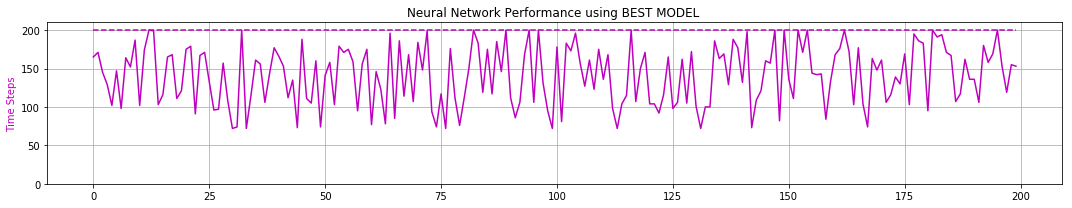

peak memory: 1465.08 MiB, increment: 1017.73 MiB
0 -max- [ 2.398  2.955  0.192  1.080]
0 -min- [-0.147 -0.732 -0.050 -0.610]

1 -max- [ 2.400  2.919  0.165  0.925]
1 -min- [-0.181 -0.577 -0.050 -0.765]

2 -max- [ 2.399  2.924  0.204  1.123]
2 -min- [-0.150 -0.623 -0.050 -0.593]

3 -max- [ 2.399  2.971  0.164  0.940]
3 -min- [-0.178 -0.578 -0.050 -0.672]

4 -max- [ 2.400  2.902  0.192  1.239]
4 -min- [-0.167 -0.608 -0.050 -0.644]

5 -max- [ 2.400  2.983  0.164  0.924]
5 -min- [-0.155 -0.579 -0.049 -0.835]

6 -max- [ 2.400  2.936  0.192  1.186]
6 -min- [-0.157 -0.773 -0.049 -0.691]

7 -max- [ 2.399  2.943  0.164  0.934]
7 -min- [-0.163 -0.579 -0.050 -0.757]

8 -max- [ 2.400  2.962  0.204  1.168]
8 -min- [-0.152 -0.735 -0.050 -0.644]

9 -max- [ 2.399  2.976  0.165  0.930]
9 -min- [-0.178 -0.627 -0.055 -0.921]

Quantization TIME:  0.02 minutes


ITERATION # 5
TOTAL EXPERIENCE GENERATED:   20824
SMALLEST TIMESTEP: 10
LARGEST  TIMESTEP: 122
TOTAL SERIAL TIMESTEPS:   467837
TOTAL PARALLEL TIM

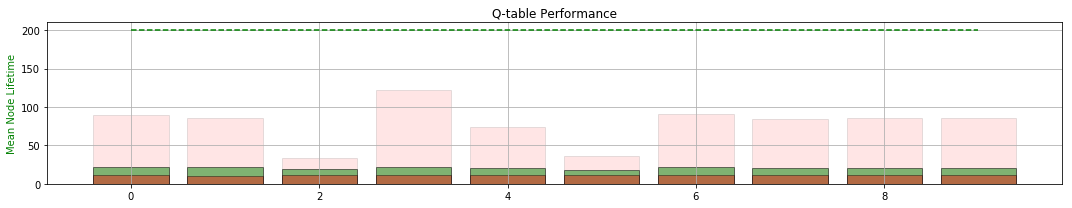

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 96.343	LOSS : 107.741	LOSS : 92.637	LOSS : 100.245	LOSS : 107.342	LOSS : 94.410	LOSS : 98.832	LOSS : 101.291	LOSS : 94.060	LOSS : 104.253	LOSS : 113.990	LOSS : 101.769	LOSS : 94.406	LOSS : 119.624	LOSS : 91.460	LOSS : 100.260	LOSS : 99.130	LOSS : 87.786	LOSS : 112.775	LOSS : 92.497	
Validating... MEAN TIME:  168.805
LOSS : 96.830	LOSS : 103.074	LOSS : 105.980	LOSS : 99.671	LOSS : 97.093	LOSS : 98.033	LOSS : 106.157	LOSS : 112.305	LOSS : 100.051	LOSS : 96.982	LOSS : 102.668	LOSS : 106.379	LOSS : 100.362	LOSS : 105.276	LOSS : 104.523	LOSS : 104.523	LOSS : 96.151	LOSS : 111.161	LOSS : 114.996	LOSS : 101.543	
Validating... MEAN TIME:  159.045
LOSS : 105.665	LOSS : 109.413	LOSS : 93.931	LOSS : 110.581	LOSS : 104.154	LOSS : 117.900	LOSS : 96.320	LOSS : 111.667	LOSS : 102.407	LOSS : 99.959	LOSS : 110.224	LOSS : 97.484	LOSS : 108.765	LOSS : 109.082	LOSS : 102.513	LOSS : 98.340	LOSS : 107.090	LOSS : 98.899

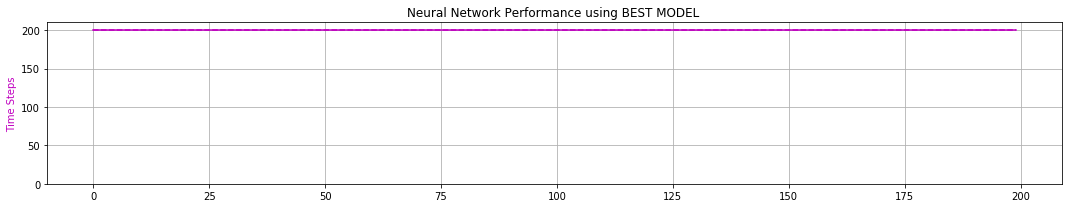

peak memory: 1441.67 MiB, increment: 978.53 MiB
0 -max- [ 0.211  1.377  0.148  1.252]
0 -min- [-0.685 -1.549 -0.209 -2.192]

1 -max- [ 0.213  0.959  0.133  0.974]
1 -min- [-0.949 -1.711 -0.209 -1.924]

2 -max- [ 0.230  0.838  0.049  0.328]
2 -min- [-0.050 -0.576 -0.209 -1.342]

3 -max- [ 0.218  0.951  0.122  1.055]
3 -min- [-2.399 -2.803 -0.209 -1.934]

4 -max- [ 0.210  1.138  0.156  0.983]
4 -min- [-0.697 -1.530 -0.209 -1.780]

5 -max- [ 0.198  0.838  0.047  0.291]
5 -min- [-0.050 -0.574 -0.209 -1.418]

6 -max- [ 0.209  0.761  0.125  1.068]
6 -min- [-0.743 -1.519 -0.209 -1.636]

7 -max- [ 0.206  0.840  0.103  0.974]
7 -min- [-0.699 -1.519 -0.209 -1.548]

8 -max- [ 0.216  0.641  0.105  0.930]
8 -min- [-0.660 -1.172 -0.209 -1.663]

9 -max- [ 0.224  0.830  0.130  1.003]
9 -min- [-0.785 -1.520 -0.209 -1.701]

Quantization TIME:  0.02 minutes


ITERATION # 6
TOTAL EXPERIENCE GENERATED:   139753
SMALLEST TIMESTEP: 26
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   607590
TOTAL PARALLEL TIM

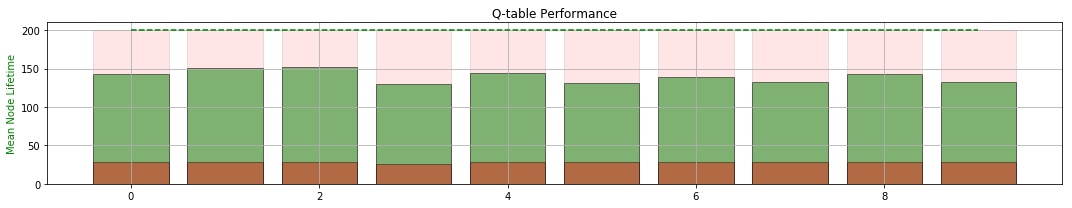

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 112.949	LOSS : 107.823	LOSS : 106.234	LOSS : 102.894	LOSS : 110.695	LOSS : 107.369	LOSS : 108.759	LOSS : 115.289	LOSS : 109.051	LOSS : 115.686	LOSS : 120.322	LOSS : 115.480	LOSS : 117.213	LOSS : 111.597	LOSS : 111.530	LOSS : 108.896	LOSS : 107.570	LOSS : 115.034	LOSS : 119.742	LOSS : 107.007	
Validating... MEAN TIME:  91.86
LOSS : 124.376	LOSS : 115.438	LOSS : 105.388	LOSS : 127.007	LOSS : 121.551	LOSS : 118.622	LOSS : 117.613	LOSS : 114.192	LOSS : 113.563	LOSS : 114.452	LOSS : 109.060	LOSS : 102.742	LOSS : 116.448	LOSS : 103.446	LOSS : 111.558	LOSS : 109.731	LOSS : 115.705	LOSS : 110.598	LOSS : 101.473	LOSS : 102.409	
Validating... MEAN TIME:  110.95
LOSS : 113.912	LOSS : 100.440	LOSS : 114.369	LOSS : 112.041	LOSS : 110.375	LOSS : 109.663	LOSS : 105.077	LOSS : 114.966	LOSS : 106.554	LOSS : 116.601	LOSS : 105.267	LOSS : 113.276	LOSS : 114.302	LOSS : 109.634	LOSS : 117.031	LOSS : 122.737	LOSS : 99.

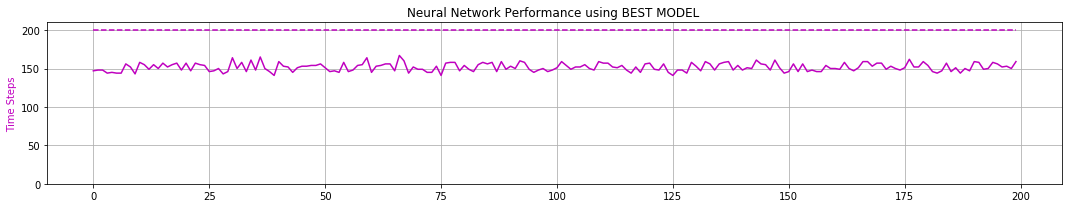

peak memory: 1499.03 MiB, increment: 996.94 MiB
0 -max- [ 0.925  2.286  0.204  1.252]
0 -min- [-0.206 -1.003 -0.209 -2.439]

1 -max- [ 0.928  2.090  0.175  1.041]
1 -min- [-0.233 -1.005 -0.209 -2.469]

2 -max- [ 0.930  1.969  0.174  1.099]
2 -min- [-0.224 -0.960 -0.209 -2.286]

3 -max- [ 0.929  2.082  0.172  1.041]
3 -min- [-0.248 -0.997 -0.209 -2.486]

4 -max- [ 0.931  2.278  0.207  1.314]
4 -min- [-0.265 -1.131 -0.209 -2.477]

5 -max- [ 0.938  1.968  0.171  1.042]
5 -min- [-0.216 -0.968 -0.209 -2.330]

6 -max- [ 0.930  2.043  0.180  1.192]
6 -min- [-0.176 -0.989 -0.209 -2.285]

7 -max- [ 0.934  1.957  0.169  1.041]
7 -min- [-0.204 -0.944 -0.209 -2.283]

8 -max- [ 0.940  2.061  0.199  1.287]
8 -min- [-0.200 -0.983 -0.208 -2.283]

9 -max- [ 0.931  1.974  0.173  1.043]
9 -min- [-0.254 -0.996 -0.209 -2.407]

Quantization TIME:  0.02 minutes


ITERATION # 7
TOTAL EXPERIENCE GENERATED:   110479
SMALLEST TIMESTEP: 14
LARGEST  TIMESTEP: 122
TOTAL SERIAL TIMESTEPS:   718069
TOTAL PARALLEL TIM

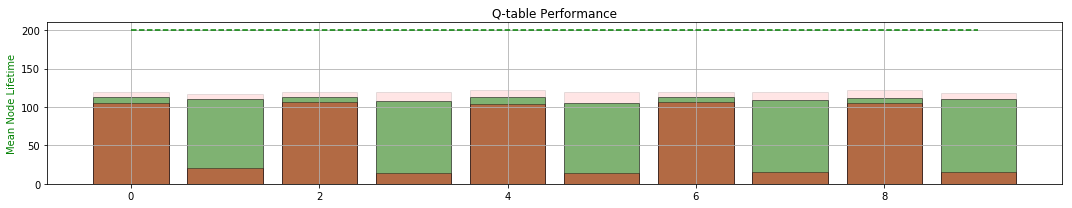

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 102.832	LOSS : 94.202	LOSS : 109.392	LOSS : 104.079	LOSS : 104.421	LOSS : 98.979	LOSS : 84.977	LOSS : 98.535	LOSS : 101.845	LOSS : 90.992	LOSS : 82.810	LOSS : 88.706	LOSS : 84.666	LOSS : 81.413	LOSS : 91.885	LOSS : 93.510	LOSS : 88.829	LOSS : 80.270	LOSS : 96.401	LOSS : 78.094	
Validating... MEAN TIME:  124.905
LOSS : 94.941	LOSS : 99.093	LOSS : 93.618	LOSS : 87.442	LOSS : 83.589	LOSS : 88.163	LOSS : 83.580	LOSS : 92.069	LOSS : 85.457	LOSS : 89.766	LOSS : 95.986	LOSS : 89.820	LOSS : 88.548	LOSS : 84.508	LOSS : 97.737	LOSS : 77.319	LOSS : 82.770	LOSS : 89.878	LOSS : 78.540	LOSS : 86.039	
Validating... MEAN TIME:  118.245
LOSS : 86.835	LOSS : 89.653	LOSS : 80.978	LOSS : 92.321	LOSS : 89.989	LOSS : 86.742	LOSS : 93.982	LOSS : 74.318	LOSS : 88.827	LOSS : 85.167	LOSS : 78.247	LOSS : 80.451	LOSS : 85.083	LOSS : 85.597	LOSS : 72.488	LOSS : 89.985	LOSS : 91.486	LOSS : 79.008	LOSS : 72.809	LOSS : 81.810	
V

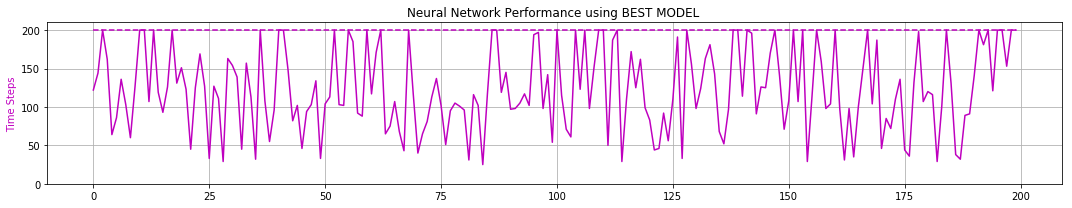

peak memory: 1480.88 MiB, increment: 1017.58 MiB
0 -max- [ 0.215  1.018  0.057  1.203]
0 -min- [-2.400 -2.624 -0.204 -1.458]

1 -max- [ 0.201  1.022  0.051  0.878]
1 -min- [-2.398 -2.629 -0.207 -1.450]

2 -max- [ 0.200  1.019  0.090  1.287]
2 -min- [-2.400 -2.583 -0.204 -1.452]

3 -max- [ 0.192  1.016  0.047  1.211]
3 -min- [-2.400 -2.909 -0.209 -1.512]

4 -max- [ 0.199  1.007  0.080  1.265]
4 -min- [-2.399 -2.604 -0.203 -1.453]

5 -max- [ 0.192  1.014  0.049  1.205]
5 -min- [-2.399 -3.147 -0.209 -1.466]

6 -max- [ 0.203  1.017  0.049  1.002]
6 -min- [-2.400 -2.607 -0.201 -1.458]

7 -max- [ 0.200  1.017  0.050  1.201]
7 -min- [-2.400 -2.824 -0.207 -1.543]

8 -max- [ 0.198  1.018  0.048  0.962]
8 -min- [-2.400 -2.588 -0.204 -1.474]

9 -max- [ 0.178  1.009  0.045  0.743]
9 -min- [-2.400 -2.595 -0.207 -1.463]

Quantization TIME:  0.02 minutes


ITERATION # 8
TOTAL EXPERIENCE GENERATED:   81734
SMALLEST TIMESTEP: 13
LARGEST  TIMESTEP: 118
TOTAL SERIAL TIMESTEPS:   799803
TOTAL PARALLEL TIM

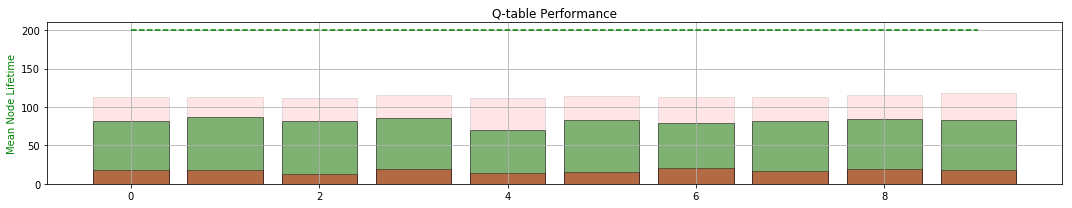

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 120.664	LOSS : 117.056	LOSS : 102.818	LOSS : 108.420	LOSS : 104.417	LOSS : 96.088	LOSS : 95.101	LOSS : 85.980	LOSS : 76.357	LOSS : 97.906	LOSS : 88.469	LOSS : 84.862	LOSS : 94.823	LOSS : 89.950	LOSS : 83.704	LOSS : 94.468	LOSS : 86.658	LOSS : 82.424	LOSS : 87.785	LOSS : 86.043	
Validating... MEAN TIME:  189.565
LOSS : 79.279	LOSS : 90.557	LOSS : 80.320	LOSS : 86.904	LOSS : 81.001	LOSS : 88.548	LOSS : 82.428	LOSS : 84.879	LOSS : 84.897	LOSS : 89.553	LOSS : 81.942	LOSS : 82.830	LOSS : 85.932	LOSS : 74.870	LOSS : 82.971	LOSS : 84.586	LOSS : 73.518	LOSS : 93.514	LOSS : 80.183	LOSS : 87.299	
Validating... MEAN TIME:  98.935
LOSS : 80.837	LOSS : 94.214	LOSS : 81.296	LOSS : 90.482	LOSS : 79.783	LOSS : 79.556	LOSS : 89.240	LOSS : 100.743	LOSS : 81.613	LOSS : 86.394	LOSS : 83.473	LOSS : 82.443	LOSS : 78.622	LOSS : 75.223	LOSS : 78.410	LOSS : 83.543	LOSS : 79.028	LOSS : 88.789	LOSS : 81.164	LOSS : 81.238	
V

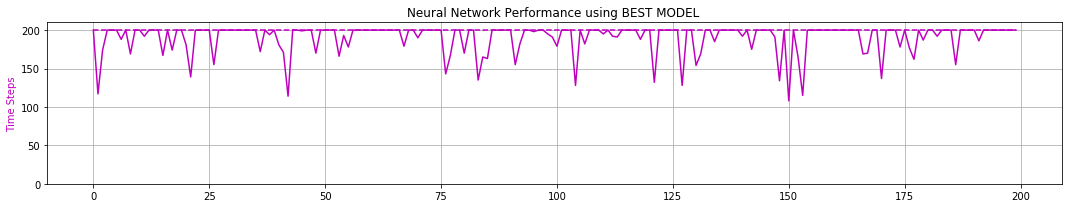

peak memory: 1488.38 MiB, increment: 1072.07 MiB
0 -max- [ 2.397  3.517  0.209  1.217]
0 -min- [-0.190 -0.776 -0.050 -1.292]

1 -max- [ 2.399  3.527  0.209  1.210]
1 -min- [-0.199 -0.775 -0.055 -1.378]

2 -max- [ 2.400  3.532  0.209  1.440]
2 -min- [-0.187 -0.934 -0.049 -1.337]

3 -max- [ 2.400  3.524  0.209  1.240]
3 -min- [-0.189 -0.774 -0.050 -1.300]

4 -max- [ 2.398  3.687  0.209  1.332]
4 -min- [-0.175 -0.774 -0.050 -1.553]

5 -max- [ 2.399  3.510  0.209  1.210]
5 -min- [-0.199 -0.772 -0.048 -1.299]

6 -max- [ 2.400  3.532  0.209  1.459]
6 -min- [-0.202 -0.938 -0.049 -1.298]

7 -max- [ 2.400  3.480  0.209  1.266]
7 -min- [-0.183 -0.775 -0.047 -1.260]

8 -max- [ 2.397  3.560  0.209  1.244]
8 -min- [-0.204 -0.816 -0.050 -1.304]

9 -max- [ 2.399  3.535  0.209  1.224]
9 -min- [-0.193 -0.772 -0.050 -1.399]

Quantization TIME:  0.02 minutes


ITERATION # 9
TOTAL EXPERIENCE GENERATED:   135741
SMALLEST TIMESTEP: 71
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   935544
TOTAL PARALLEL TI

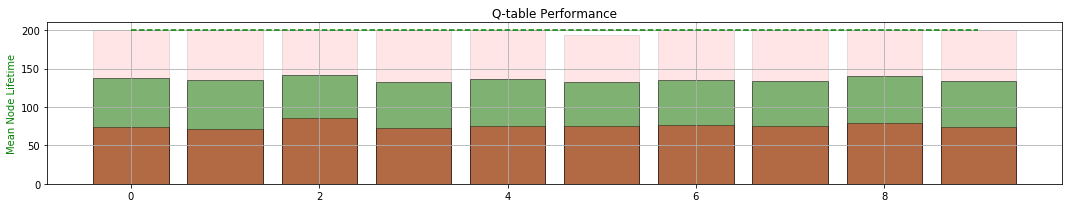

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 106.185	LOSS : 90.973	LOSS : 102.503	LOSS : 87.688	LOSS : 97.716	LOSS : 84.296	LOSS : 74.609	LOSS : 79.498	LOSS : 82.390	LOSS : 79.550	LOSS : 86.401	LOSS : 84.494	LOSS : 80.836	LOSS : 82.408	LOSS : 81.300	LOSS : 82.312	LOSS : 78.399	LOSS : 75.561	LOSS : 89.040	LOSS : 79.122	
Validating... MEAN TIME:  200.0
LOSS : 85.322	LOSS : 82.627	LOSS : 78.050	LOSS : 70.941	LOSS : 69.184	LOSS : 77.389	LOSS : 77.462	LOSS : 73.728	LOSS : 86.205	LOSS : 82.244	LOSS : 80.746	LOSS : 77.768	LOSS : 82.290	LOSS : 73.144	LOSS : 84.753	LOSS : 88.861	LOSS : 81.164	LOSS : 90.510	LOSS : 86.261	LOSS : 77.749	
Validating... MEAN TIME:  200.0
LOSS : 79.026	LOSS : 77.591	LOSS : 77.908	LOSS : 79.540	LOSS : 79.027	LOSS : 84.308	LOSS : 84.505	LOSS : 81.010	LOSS : 79.793	LOSS : 91.871	LOSS : 76.004	LOSS : 83.131	LOSS : 78.029	LOSS : 78.470	LOSS : 72.915	LOSS : 86.849	LOSS : 85.798	LOSS : 85.914	LOSS : 82.530	LOSS : 92.731	
Validati

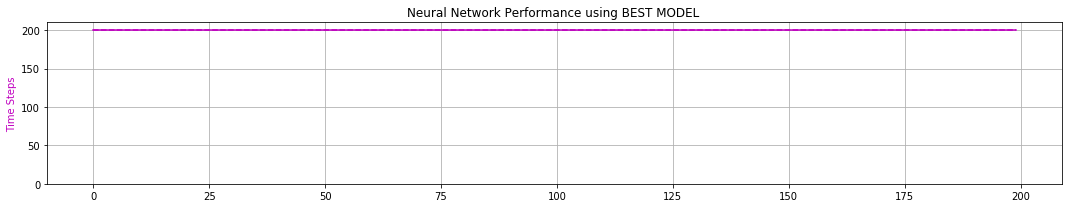

peak memory: 1472.71 MiB, increment: 997.81 MiB
0 -max- [ 1.142  2.042  0.131  1.852]
0 -min- [-2.398 -3.665 -0.209 -1.284]

1 -max- [ 0.263  0.620  0.062  1.853]
1 -min- [-2.399 -3.672 -0.209 -1.934]

2 -max- [ 1.006  2.039  0.129  1.966]
2 -min- [-2.400 -3.717 -0.209 -2.010]

3 -max- [ 1.232  2.204  0.120  1.911]
3 -min- [-2.400 -3.746 -0.209 -2.054]

4 -max- [ 0.807  2.005  0.127  1.882]
4 -min- [-2.399 -3.758 -0.209 -1.830]

5 -max- [ 0.289  0.609  0.105  1.874]
5 -min- [-2.400 -3.762 -0.209 -1.937]

6 -max- [ 0.263  0.577  0.093  1.844]
6 -min- [-2.399 -3.760 -0.209 -1.797]

7 -max- [ 1.205  2.048  0.123  1.897]
7 -min- [-2.400 -3.757 -0.209 -2.115]

8 -max- [ 1.274  2.207  0.135  1.955]
8 -min- [-2.399 -3.769 -0.209 -1.942]

9 -max- [ 0.726  1.847  0.131  1.833]
9 -min- [-2.400 -3.533 -0.209 -1.843]

Quantization TIME:  0.01 minutes


ITERATION # 10
TOTAL EXPERIENCE GENERATED:   142534
SMALLEST TIMESTEP: 113
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   1078078
TOTAL PARALLEL 

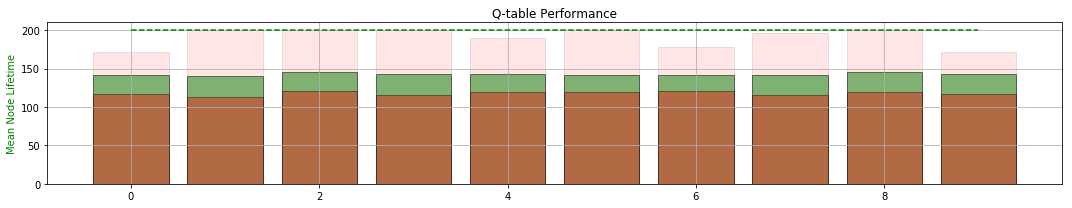

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 92.850	LOSS : 81.926	LOSS : 85.696	LOSS : 84.040	LOSS : 78.584	LOSS : 73.002	LOSS : 80.663	LOSS : 76.527	LOSS : 77.397	LOSS : 83.316	LOSS : 77.771	LOSS : 67.657	LOSS : 67.739	LOSS : 68.264	LOSS : 62.932	LOSS : 75.271	LOSS : 64.213	LOSS : 66.842	LOSS : 64.559	LOSS : 64.932	
Validating... MEAN TIME:  106.36
LOSS : 70.131	LOSS : 69.601	LOSS : 61.548	LOSS : 67.784	LOSS : 64.045	LOSS : 67.681	LOSS : 75.124	LOSS : 64.359	LOSS : 53.039	LOSS : 72.257	LOSS : 75.204	LOSS : 65.838	LOSS : 72.208	LOSS : 67.248	LOSS : 60.158	LOSS : 68.288	LOSS : 73.401	LOSS : 72.147	LOSS : 66.513	LOSS : 58.876	
Validating... MEAN TIME:  110.3
LOSS : 66.331	LOSS : 64.960	LOSS : 77.199	LOSS : 73.912	LOSS : 83.565	LOSS : 74.442	LOSS : 66.550	LOSS : 68.728	LOSS : 74.976	LOSS : 52.909	LOSS : 61.474	LOSS : 76.505	LOSS : 69.818	LOSS : 66.657	LOSS : 71.488	LOSS : 77.419	LOSS : 67.313	LOSS : 67.273	LOSS : 61.544	LOSS : 59.365	
Validatin

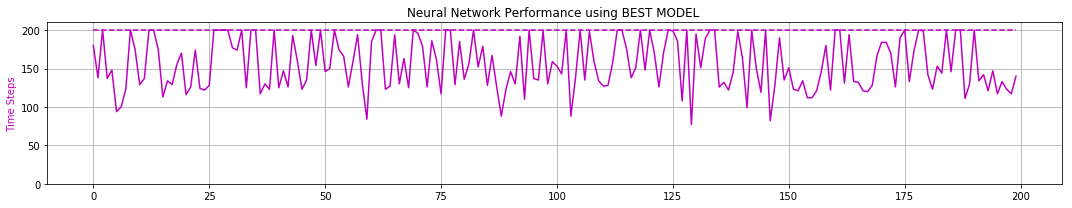

peak memory: 1459.91 MiB, increment: 978.16 MiB
0 -max- [ 0.166  0.432  0.047  0.883]
0 -min- [-2.399 -2.973 -0.209 -0.950]

1 -max- [ 0.252  0.612  0.048  0.919]
1 -min- [-2.398 -3.102 -0.208 -1.241]

2 -max- [ 0.194  0.598  0.049  0.902]
2 -min- [-2.400 -2.947 -0.209 -0.963]

3 -max- [ 0.211  0.627  0.049  0.915]
3 -min- [-2.399 -2.961 -0.209 -0.998]

4 -max- [ 0.189  0.623  0.050  0.904]
4 -min- [-2.399 -2.952 -0.209 -1.016]

5 -max- [ 0.280  0.621  0.048  0.910]
5 -min- [-2.400 -2.969 -0.207 -1.131]

6 -max- [ 0.163  0.614  0.045  0.915]
6 -min- [-2.400 -2.958 -0.209 -1.020]

7 -max- [ 0.206  0.800  0.050  0.922]
7 -min- [-2.400 -2.989 -0.209 -1.223]

8 -max- [ 0.212  0.626  0.049  0.951]
8 -min- [-2.399 -2.983 -0.209 -1.064]

9 -max- [ 0.188  0.630  0.050  0.909]
9 -min- [-2.400 -2.973 -0.209 -0.802]

Quantization TIME:  0.01 minutes


ITERATION # 11
TOTAL EXPERIENCE GENERATED:   62515
SMALLEST TIMESTEP: 11
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   1140593
TOTAL PARALLEL TI

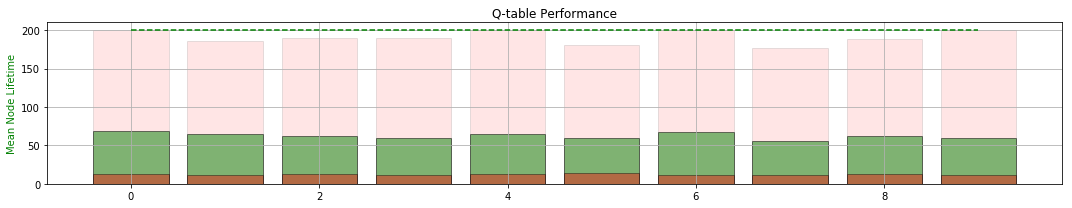

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 108.928	LOSS : 98.191	LOSS : 108.099	LOSS : 123.485	LOSS : 122.979	LOSS : 129.978	LOSS : 131.562	LOSS : 144.510	LOSS : 112.082	LOSS : 121.563	LOSS : 119.847	LOSS : 122.477	LOSS : 106.019	LOSS : 110.653	LOSS : 104.567	LOSS : 122.596	LOSS : 117.373	LOSS : 113.520	LOSS : 117.933	LOSS : 110.059	
Validating... MEAN TIME:  109.055
LOSS : 114.064	LOSS : 114.607	LOSS : 114.783	LOSS : 110.801	LOSS : 102.674	LOSS : 107.000	LOSS : 127.164	LOSS : 107.092	LOSS : 115.249	LOSS : 121.680	LOSS : 126.254	LOSS : 109.765	LOSS : 96.103	LOSS : 104.705	LOSS : 109.303	LOSS : 101.731	LOSS : 99.038	LOSS : 111.953	LOSS : 98.447	LOSS : 112.305	
Validating... MEAN TIME:  95.83
LOSS : 114.520	LOSS : 97.770	LOSS : 99.739	LOSS : 96.428	LOSS : 111.996	LOSS : 108.123	LOSS : 102.111	LOSS : 109.838	LOSS : 113.685	LOSS : 96.199	LOSS : 99.604	LOSS : 97.010	LOSS : 90.204	LOSS : 101.616	LOSS : 98.817	LOSS : 124.075	LOSS : 110.543	LOSS :

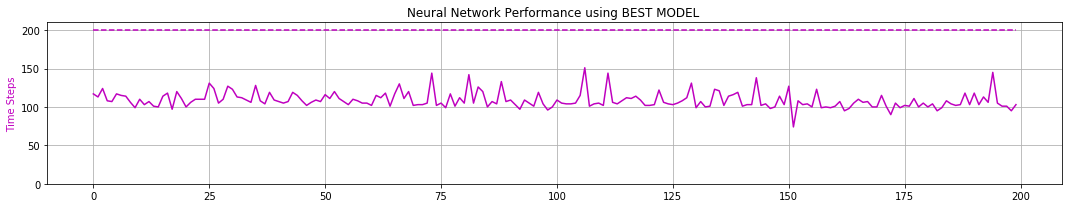

peak memory: 1431.83 MiB, increment: 1036.64 MiB
0 -max- [ 2.395  3.693  0.207  2.146]
0 -min- [-0.836 -2.450 -0.209 -1.688]

1 -max- [ 2.386  3.483  0.197  2.135]
1 -min- [-0.843 -2.473 -0.209 -1.968]

2 -max- [ 2.378  3.540  0.199  2.022]
2 -min- [-0.835 -2.289 -0.209 -1.701]

3 -max- [ 2.398  3.674  0.197  1.897]
3 -min- [-0.908 -2.284 -0.209 -1.669]

4 -max- [ 2.390  3.494  0.208  1.977]
4 -min- [-0.819 -2.274 -0.209 -1.679]

5 -max- [ 2.391  3.472  0.187  1.922]
5 -min- [-0.949 -2.290 -0.209 -1.882]

6 -max- [ 2.398  3.695  0.207  2.029]
6 -min- [-0.862 -2.267 -0.209 -1.671]

7 -max- [ 2.377  3.483  0.193  1.914]
7 -min- [-0.809 -2.277 -0.209 -1.838]

8 -max- [ 2.377  3.689  0.201  1.932]
8 -min- [-0.887 -2.289 -0.209 -1.650]

9 -max- [ 2.392  3.474  0.194  2.082]
9 -min- [-0.822 -2.442 -0.209 -1.683]

Quantization TIME:  0.01 minutes


ITERATION # 12
TOTAL EXPERIENCE GENERATED:   136050
SMALLEST TIMESTEP: 11
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   1276643
TOTAL PARALLEL 

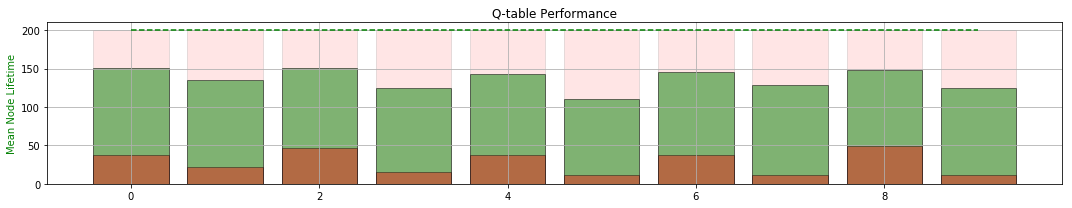

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 220.191	LOSS : 189.132	LOSS : 160.869	LOSS : 137.387	LOSS : 154.120	LOSS : 140.445	LOSS : 147.577	LOSS : 147.725	LOSS : 143.386	LOSS : 123.678	LOSS : 145.133	LOSS : 130.163	LOSS : 156.840	LOSS : 122.758	LOSS : 143.221	LOSS : 148.597	LOSS : 157.715	LOSS : 139.858	LOSS : 144.644	LOSS : 159.797	
Validating... MEAN TIME:  121.52
LOSS : 143.218	LOSS : 155.810	LOSS : 152.636	LOSS : 163.459	LOSS : 163.429	LOSS : 138.147	LOSS : 141.255	LOSS : 155.068	LOSS : 150.298	LOSS : 154.893	LOSS : 155.218	LOSS : 155.184	LOSS : 158.626	LOSS : 147.799	LOSS : 154.791	LOSS : 159.005	LOSS : 149.079	LOSS : 167.487	LOSS : 150.400	LOSS : 160.291	
Validating... MEAN TIME:  147.555
LOSS : 151.237	LOSS : 146.668	LOSS : 136.686	LOSS : 149.438	LOSS : 150.848	LOSS : 149.702	LOSS : 144.745	LOSS : 154.946	LOSS : 146.335	LOSS : 158.900	LOSS : 168.731	LOSS : 160.699	LOSS : 145.535	LOSS : 150.593	LOSS : 141.526	LOSS : 136.287	LOSS : 1

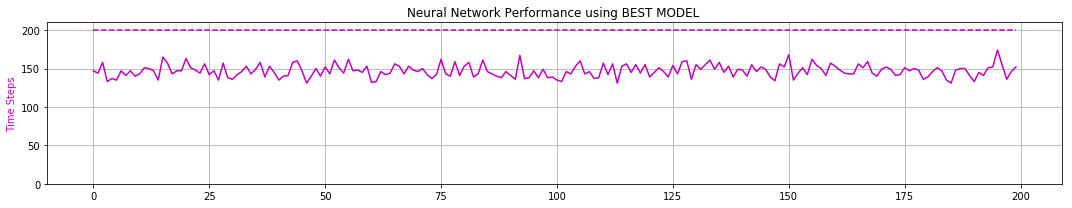

peak memory: 1481.15 MiB, increment: 1027.23 MiB
0 -max- [ 2.399  3.114  0.202  2.166]
0 -min- [-2.395 -3.097 -0.209 -2.275]

1 -max- [ 2.394  2.643  0.149  1.951]
1 -min- [-2.385 -3.081 -0.209 -2.280]

2 -max- [ 2.398  3.681  0.205  1.980]
2 -min- [-2.381 -3.133 -0.209 -2.058]

3 -max- [ 2.395  3.145  0.180  1.929]
3 -min- [-2.399 -2.956 -0.209 -2.081]

4 -max- [ 2.257  3.501  0.197  1.941]
4 -min- [-2.398 -2.953 -0.209 -1.979]

5 -max- [ 2.398  2.591  0.146  1.902]
5 -min- [-2.400 -2.968 -0.209 -2.057]

6 -max- [ 2.400  3.673  0.206  2.184]
6 -min- [-2.391 -3.014 -0.209 -2.204]

7 -max- [ 1.633  2.465  0.141  1.917]
7 -min- [-2.377 -3.012 -0.209 -2.171]

8 -max- [ 2.385  3.688  0.195  1.998]
8 -min- [-2.399 -3.023 -0.209 -2.029]

9 -max- [ 2.387  2.817  0.152  1.954]
9 -min- [-2.399 -2.967 -0.209 -2.149]

Quantization TIME:  0.02 minutes


ITERATION # 13
TOTAL EXPERIENCE GENERATED:   141424
SMALLEST TIMESTEP: 61
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   1418067
TOTAL PARALLEL 

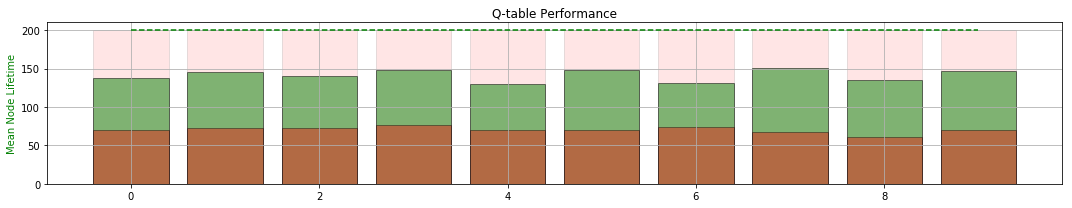

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 97.725	LOSS : 101.270	LOSS : 106.523	LOSS : 96.241	LOSS : 100.097	LOSS : 84.466	LOSS : 95.868	LOSS : 99.931	LOSS : 89.846	LOSS : 87.388	LOSS : 93.801	LOSS : 95.545	LOSS : 81.198	LOSS : 87.941	LOSS : 99.502	LOSS : 88.747	LOSS : 91.787	LOSS : 80.978	LOSS : 102.548	LOSS : 77.312	
Validating... MEAN TIME:  200.0
LOSS : 88.218	LOSS : 93.431	LOSS : 94.416	LOSS : 94.735	LOSS : 91.164	LOSS : 81.644	LOSS : 88.811	LOSS : 92.413	LOSS : 80.969	LOSS : 93.113	LOSS : 76.510	LOSS : 85.923	LOSS : 87.400	LOSS : 92.160	LOSS : 96.614	LOSS : 85.677	LOSS : 84.425	LOSS : 79.860	LOSS : 89.261	LOSS : 103.040	
Validating... MEAN TIME:  197.06
LOSS : 107.530	LOSS : 78.111	LOSS : 85.396	LOSS : 107.981	LOSS : 83.563	LOSS : 112.141	LOSS : 90.880	LOSS : 84.417	LOSS : 94.711	LOSS : 91.874	LOSS : 93.019	LOSS : 77.145	LOSS : 91.162	LOSS : 89.510	LOSS : 88.569	LOSS : 109.196	LOSS : 94.045	LOSS : 94.321	LOSS : 95.045	LOSS : 92.293	


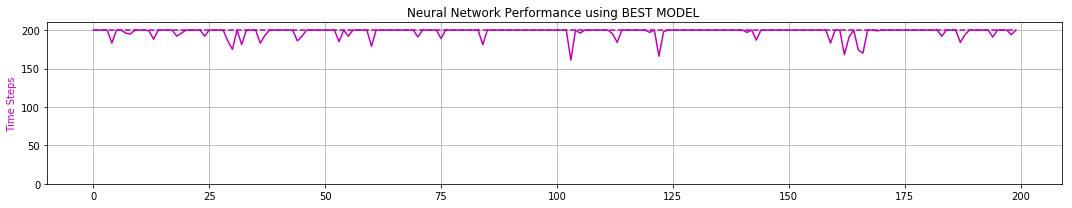

peak memory: 1517.75 MiB, increment: 1041.65 MiB
0 -max- [ 2.400  3.505  0.209  1.004]
0 -min- [-2.397 -2.391 -0.208 -1.639]

1 -max- [ 2.400  3.667  0.209  0.913]
1 -min- [-2.380 -2.362 -0.209 -1.744]

2 -max- [ 2.392  3.573  0.209  1.102]
2 -min- [-2.391 -2.370 -0.209 -1.795]

3 -max- [ 2.393  3.539  0.209  0.818]
3 -min- [-2.393 -2.373 -0.209 -1.679]

4 -max- [ 2.397  3.704  0.209  1.212]
4 -min- [-2.392 -2.370 -0.209 -1.833]

5 -max- [ 2.396  3.679  0.209  0.999]
5 -min- [-2.400 -2.370 -0.209 -1.734]

6 -max- [ 2.394  3.516  0.209  1.086]
6 -min- [-2.399 -2.343 -0.209 -1.625]

7 -max- [ 2.399  3.577  0.209  1.045]
7 -min- [-2.396 -2.396 -0.208 -1.859]

8 -max- [ 2.398  3.534  0.209  0.943]
8 -min- [-2.395 -2.363 -0.208 -1.680]

9 -max- [ 2.397  3.535  0.209  0.864]
9 -min- [-2.385 -2.417 -0.209 -1.710]

Quantization TIME:  0.01 minutes


ITERATION # 14
TOTAL EXPERIENCE GENERATED:   197388
SMALLEST TIMESTEP: 132
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   1615455
TOTAL PARALLEL

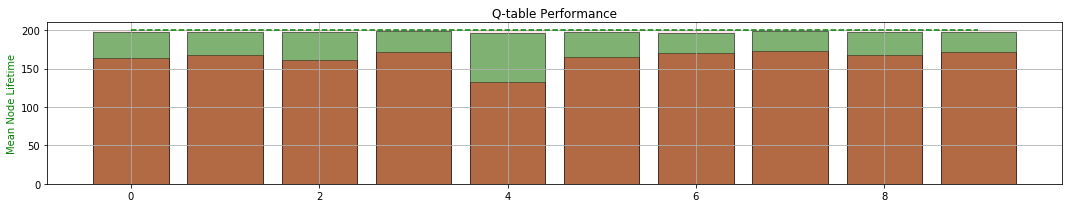

In [20]:
while iteration < MAX_NO_OF_ITERATIONS:

    print("\n")
    print("ITERATION #", iteration)
    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    q_table_list = [node_q_table]* NO_OF_NODES
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list, q_table_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)
    
    print("TOTAL EXPERIENCE GENERATED:   {:d}".format(EXP_GEN.astype(int)))

    print("SMALLEST TIMESTEP: {:d}".format(node_time_rec.min().astype(int)))
    print("LARGEST  TIMESTEP: {:d}".format(node_time_rec.max().astype(int)))

    print("TOTAL SERIAL TIMESTEPS:   {:d}".format(total_serial_timesteps.astype(int)))
    print("TOTAL PARALLEL TIMESTEPS: {:d}".format(total_parallel_timesteps.astype(int)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_avg_time[node_avg_time >= 195].shape[0] > NO_OF_NODES/2:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    dqn.memory = np.insert(dqn.memory,0,all_exp,0)
    dqn.memory = dqn.memory[:MIN_MEMORY_CAP,:]
    dqn.memory_counter += all_exp.shape[0]
#     good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
#     bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


#     dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
#     dqn.good_memory_counter += good_mem.shape[0]

#     dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
#     dqn.bad_memory_counter += bad_mem.shape[0]

#     dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
#     dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS
    print("MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.memory_counter))

#     print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
#     print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("\nValidating... ",end="")
            time_rec = []
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()

                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)

                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                nn_level_up_metric = clamp(0, nn_level_up_metric, 195)
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        time_step = 0
        s = env.reset()

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    
        
    ##################################################################
    
    # CREATE ONE LARGE Q-TABLES FROM WHICH THE NODES STRIP
    ##################################################################
        
#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN * NO_OF_NODES  ])
    
    start = timeit.default_timer()
    # GET Q-VALUES 
    %memit node_q_table = best_dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)

    # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
    stop = timeit.default_timer()

#     ##################################################################
    
#     # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
#     ##################################################################
    
    for node_id in range(NO_OF_NODES):
# #         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
# #         ###############################################
#         [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
#          C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
# #         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
# #         node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
# #                                     C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
# #         # CREATE STATE COMBINATIONS
# #         ###############################################

#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
#         ###############################################
#     start = timeit.default_timer()
#     # GET Q-VALUES 
#     %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

#     # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
#         #############################################################################################################################################
#     stop = timeit.default_timer()
    print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()

In [21]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  2560.0
Total Serial Timesteps   :  1615455.0
Speed-up                 :  631.04


In [22]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [23]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))

  7551 SUCCESS 132  14    2560    1615455     631.04
